In [104]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Model
from tensorflow.keras.applications import VGG16

In [105]:
Image_size = 360
Batch_size = 32
Channels=3
Epochs=50

In [106]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "combined",
    shuffle=True,
    image_size = (Image_size,Image_size),
    batch_size = Batch_size
)

Found 700 files belonging to 2 classes.


In [107]:
class_names = dataset.class_names
class_names

['cancer', 'non_cancer']

In [108]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


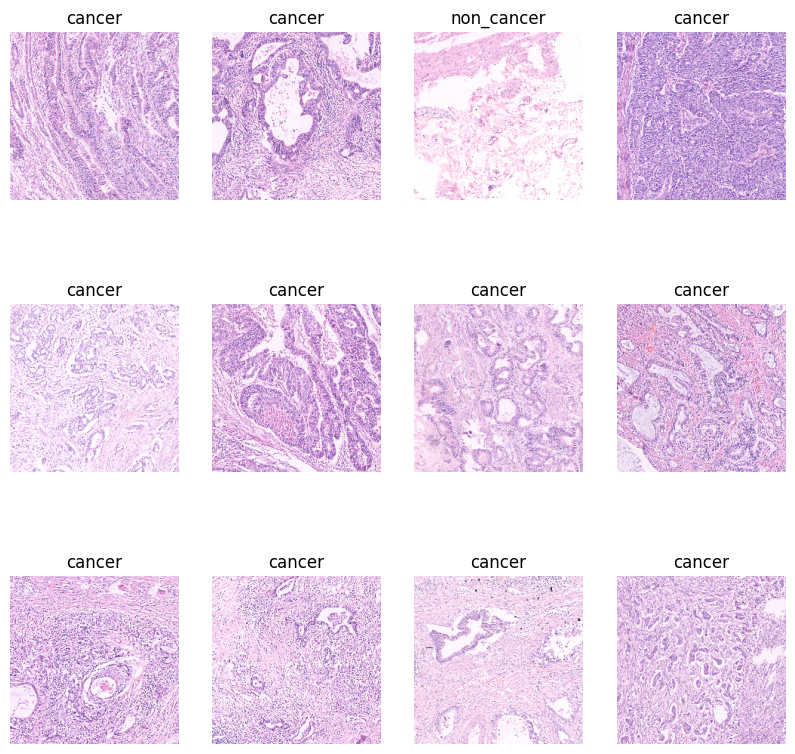

In [109]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [110]:
def dataset_partition(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    dataset_size=len(dataset)

    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*dataset_size)
    val_size=int(val_split*dataset_size)
    Train_dataset= dataset.take(train_size)
    Val_dataset=dataset.skip(train_size).take(val_size)
    Test_dataset=dataset.skip(train_size).skip(val_size)
    return Train_dataset,Val_dataset,Test_dataset

In [111]:
Train_dataset,Val_dataset,Test_dataset=dataset_partition(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000)

In [9]:
len(Train_dataset)

17

In [10]:
len(Val_dataset)

2

In [11]:
len(Test_dataset)

3

In [112]:
Train_dataset=Train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_dataset=Val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_dataset=Test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [113]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size,Image_size),
    layers.Rescaling(1.0 / 255)
])

In [114]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [38]:
input_shape=(Batch_size,Image_size,Image_size,Channels)
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(3,activation='softmax')
])

model.build(input_shape=input_shape)

In [116]:
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [118]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [121]:
history = model.fit(
    Train_dataset,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=Val_dataset
)

Epoch 1/50


In [43]:
scores= model.evaluate(Test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 892ms/step - accuracy: 0.9141 - loss: 0.2652


In [44]:
scores

[0.25511670112609863, 0.90625]

In [45]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

first image to Predict
actual label: cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
[8.8887215e-01 1.1112782e-01 3.5204397e-09]
predicted label  cancer


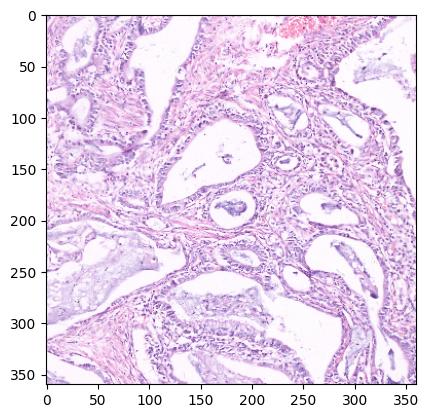

In [47]:
for image_batch,labels_batch in Test_dataset.take(1):
    first_image= image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print("first image to Predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print(batch_prediction[0])
    print("predicted label ",class_names[np.argmax(batch_prediction[0])])


In [48]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


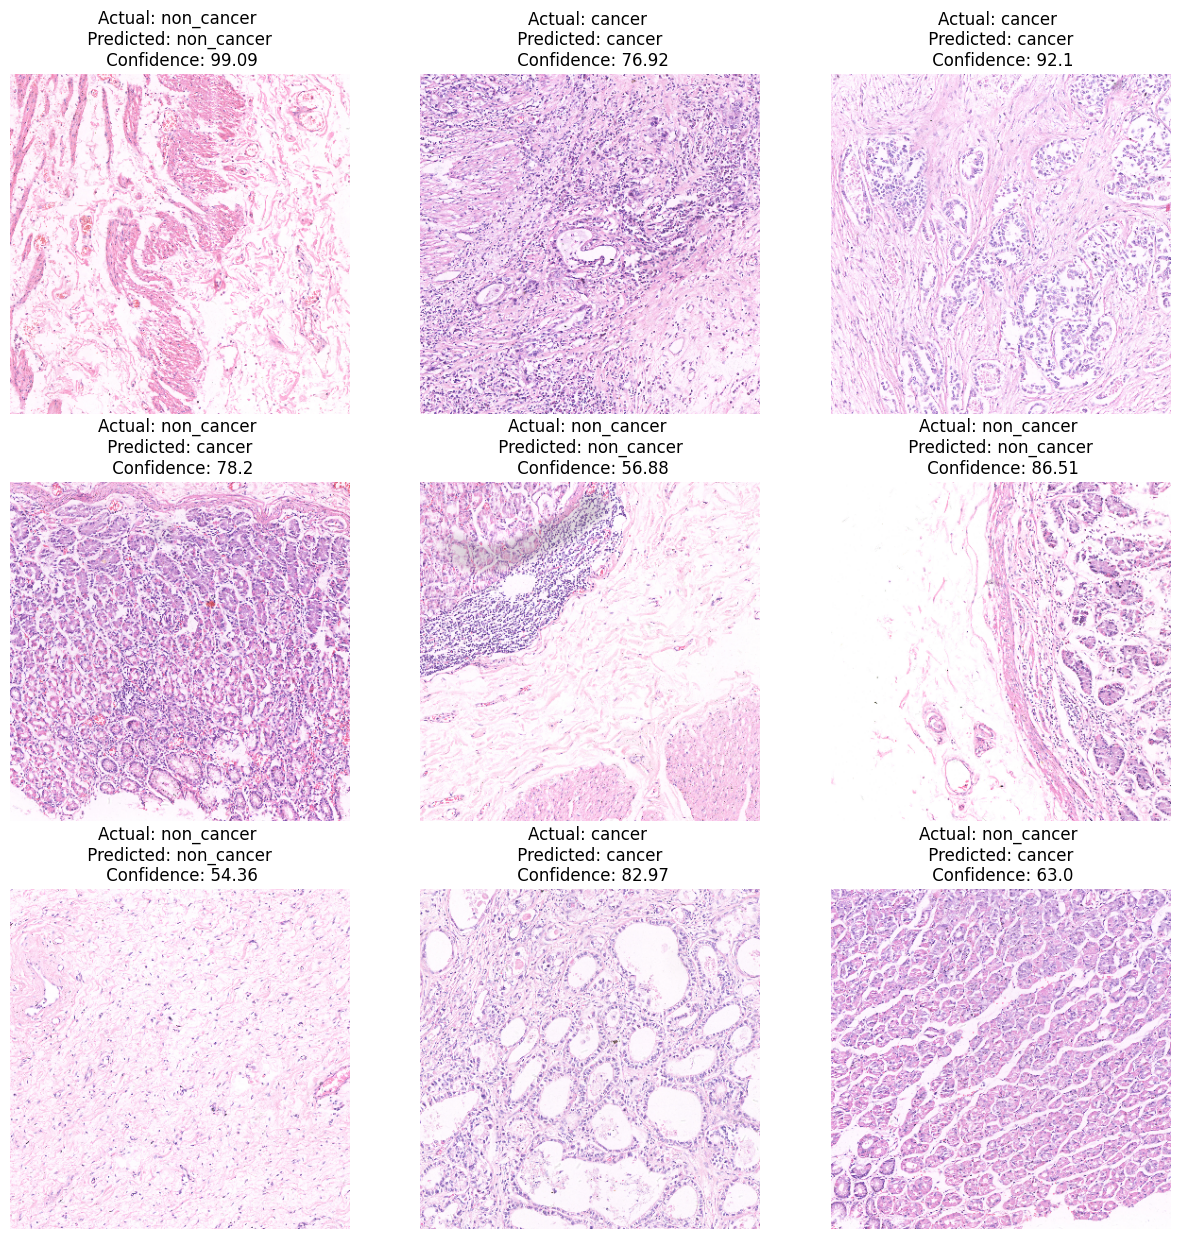

In [53]:
plt.figure(figsize=(15,15))
for images,labels in Test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}")

        plt.axis("off")

In [70]:
import os
import tensorflow as tf
from tensorflow.keras.models import model_from_json

# Directory where you want to save the model
save_directory = r"model"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Assuming you have a trained model named 'model'

# Save model architecture as JSON
model_json = model.to_json()
with open(os.path.join(save_directory, "model.json"), "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights(os.path.join(save_directory, "model_weights.weights.h5"))


In [51]:
def save_history(History):
    acc = pd.Series(History.history['accuracy'], name='accuracy')
    loss = pd.Series(History.history['loss'], name='loss')
    val_acc = pd.Series(History.history['val_accuracy'], name='val_accuracy')
    val_loss = pd.Series(History.history['val_loss'], name='val_loss')
    com = pd.concat([acc, loss, val_acc, val_loss], axis=1)
    # Be sure to update the storage location!!
    com.to_csv('D:\\meracode\\model\\history.csv')


In [52]:
save_history(history)

In [63]:
def plot_history(history):
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)
    plt.plot(range(Epochs),acc,label='Training Accuracy')
    plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(range(Epochs),loss,label='Training loss Accuracy')
    plt.plot(range(Epochs),val_loss,label='Validation loss Accuracy')
    plt.legend(loc='upper right')
    plt.title('Training loss and Validation loss Accuracy') 

    plt.tight_layout()
    plt.show()

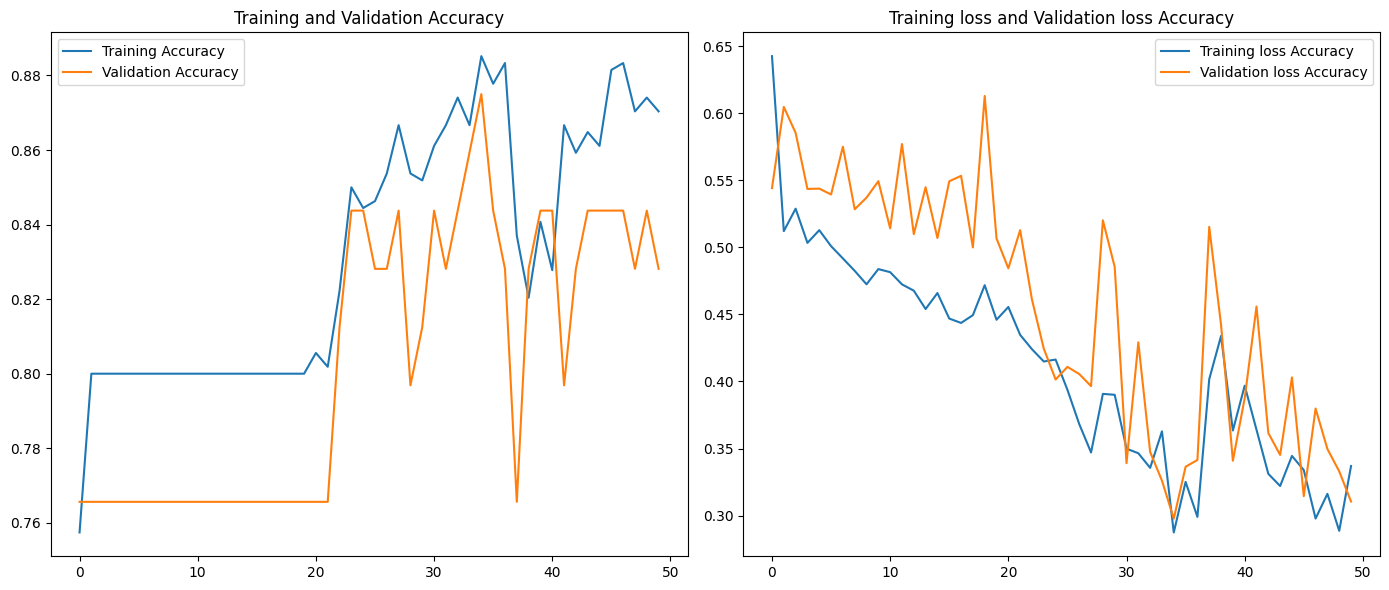

In [64]:
plot_history(history)


In [59]:

def moving_average(data, window_size):
    # Create a kernel for the moving average
    kernel = np.ones(window_size) / window_size
    # Apply the moving average filter
    smoothed_data = np.convolve(data, kernel, mode='same')
    return smoothed_data

def plot_history_smoothed(history, window_size=3):
    Epochs = len(history.history['accuracy'])
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, Epochs + 1), moving_average(history.history['accuracy'], window_size), label='Training Accuracy', marker='o')
    plt.plot(range(1, Epochs + 1), moving_average(history.history['val_accuracy'], window_size), label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (Smoothed)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, Epochs + 1), moving_average(history.history['loss'], window_size), label='Training Loss', marker='o')
    plt.plot(range(1, Epochs + 1), moving_average(history.history['val_loss'], window_size), label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Smoothed)')
    plt.legend()

    plt.tight_layout()
    plt.show()


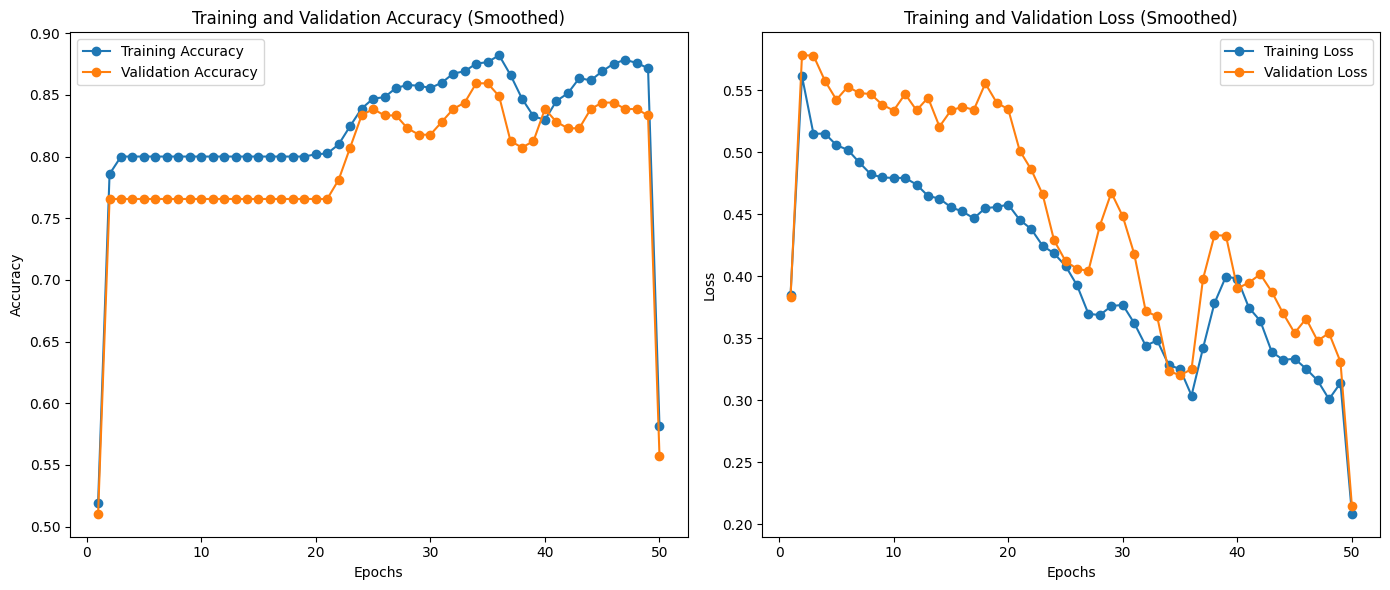

In [60]:
plot_history(history, window_size=3)